In [6]:
import torch
import torch.nn as nn
import numpy as np
from plotting import make_error_fig
from layers import StackedLinear
from activation import switchable_activation
from dataset import generate_data, kernel

# Define the device etc
# torch.set_default_dtype(torch.float64)
N_BOUND = -30 if torch.get_default_dtype() == torch.float64 else -20
DTYPE = torch.get_default_dtype()

In [7]:
# Example for a larger dataset
epochs = 2000
batch_size = 200
n_samples = batch_size * 10
prior_width = 1
unc = 0.1
seed = 42

# get reproducible datapoints
x_train, y_train = generate_data(n_samples, unc=unc, seed=seed)

# Fit scaler and save the mean and std to undo
# scaling later
Y_STD = y_train.std()
Y_MEAN = y_train.mean()
y_train_scaled = (y_train - Y_MEAN) / Y_STD

# get dataset load
dataset = torch.utils.data.TensorDataset(
    torch.tensor(x_train[:, None], dtype=DTYPE),
    torch.tensor(y_train_scaled, dtype=DTYPE),
)
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [8]:
# Example for a larger dataset
hdn_dim = 32
channels = 10
beta = 1
activation = switchable_activation("tanh")

model = nn.Sequential(
    StackedLinear(1, hdn_dim, channels),
    activation,
    StackedLinear(hdn_dim, hdn_dim, channels),
    activation,
    StackedLinear(hdn_dim, hdn_dim, channels),
    activation,
    StackedLinear(hdn_dim, hdn_dim, channels),
    activation,
    StackedLinear(hdn_dim, 2, channels),
)

opt = torch.optim.AdamW(
    model.parameters(), lr=5e-3, weight_decay=1 / (2 * len(x_train) * prior_width**2)
)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, epochs * len(loader))

for i in range(epochs):
    train_losses = np.array([])
    reg_losses = np.array([])
    for xb, yb in loader:
        h = model(xb[None, :, :].expand(channels, -1, -1))
        mu, log_sigma2 = h[:, :, 0], h[:, :, 1]

        # Heteroscedastic regression loss
        log_sigma2 = log_sigma2.clamp(N_BOUND, 11)
        reg = 0.5 * ((yb[None, :] - mu) ** 2 / log_sigma2.exp() + log_sigma2)

        # ensemble loss
        reg_mean, reg_std = reg.mean(dim=1), reg.std(dim=1)
        loss = torch.sum(reg_mean, dim=0)
        # repulsive interaction term
        k = kernel(reg, reg.detach())
        loss += beta * torch.sum(
            (k.sum(dim=1) / k.detach().sum(dim=1) - 1) / len(x_train), dim=0
        )

        train_losses = np.append(train_losses, loss.item())

        opt.zero_grad()
        loss.backward()
        opt.step()
        sched.step()

    train_losses_epoch = train_losses.mean()

    if i % 100 == 0:
        print(
            f"epoch={i}, loss={train_losses_epoch.item():.4f} "
            + f"reg-mean={reg_mean.mean().item():.4f}, std={reg_mean.std().item():.4f}, "
            + f"min={reg_mean.min().item():.4f}, max={reg_mean.max().item():.4f}"
        )

epoch=0, loss=3.0373 reg-mean=0.2832, std=0.0318, min=0.2403, max=0.3292
epoch=100, loss=0.4591 reg-mean=0.0439, std=0.1111, min=-0.1139, max=0.1580
epoch=200, loss=-5.3107 reg-mean=-0.5376, std=0.2186, min=-0.9763, max=-0.2171
epoch=300, loss=-7.5281 reg-mean=-0.7771, std=0.1886, min=-1.0351, max=-0.5149
epoch=400, loss=-9.0519 reg-mean=-0.8770, std=0.1706, min=-1.0597, max=-0.6416
epoch=500, loss=-10.0369 reg-mean=-0.9568, std=0.1072, min=-1.0542, max=-0.7432
epoch=600, loss=-10.1506 reg-mean=-1.0049, std=0.0797, min=-1.0552, max=-0.8114
epoch=700, loss=-10.2207 reg-mean=-0.9980, std=0.0803, min=-1.0814, max=-0.8351
epoch=800, loss=-10.7231 reg-mean=-1.1245, std=0.0600, min=-1.1758, max=-0.9837
epoch=900, loss=-10.8969 reg-mean=-1.0478, std=0.0236, min=-1.0790, max=-1.0024
epoch=1000, loss=-10.9401 reg-mean=-1.1828, std=0.0218, min=-1.2123, max=-1.1384
epoch=1100, loss=-11.0905 reg-mean=-1.1322, std=0.0169, min=-1.1499, max=-1.1000
epoch=1200, loss=-11.0918 reg-mean=-1.1436, std=0.02

In [9]:
# plot prediction and error bands
# note: only the predictive error is shown
# (i.e. the error from limited training statistics, as extracted by the repulsive ensemble)
means = []
sigmas2 = []
xx = torch.linspace(-1.25, 1.25, 1000, dtype=DTYPE)
yy = (0.5 * torch.sin(23 * xx) + xx / 2).numpy()

with torch.no_grad():
    x_test = xx[None, :, None].expand(channels, -1, -1)
    h_test = model(x_test)
    mus, logsigma2 = h_test[:, :, 0], h_test[:, :, 1]
    log_sigma2 = log_sigma2.clamp(N_BOUND, 11)
    sigma2 = logsigma2.exp()

means.append(mus.detach().cpu().numpy())
sigmas2.append(sigma2.detach().cpu().numpy())

mus = np.stack(means, axis=1) * Y_STD + Y_MEAN
sigmas2 = np.stack(sigmas2, axis=1)
sig = np.sqrt(sigmas2) * Y_STD

mean = np.squeeze(mus.mean(axis=0))
std = np.squeeze(mus.std(axis=0))
sigmean = np.squeeze(sig.mean(axis=0))

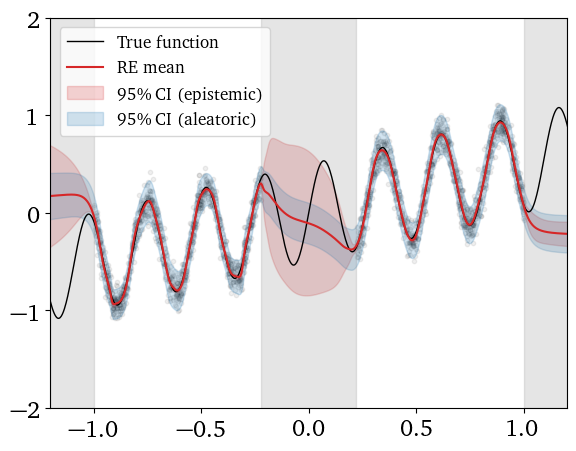

In [10]:
make_error_fig(
    data_train=(x_train, y_train),
    x_values=xx,
    y_mean=mean,
    y_std_epistemic=std,
    y_std_aleatoric=sigmean,
    network_name="RE",
    filename="repulsive_toy",
)